# Imports

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import networkx as nx
import pickle
%matplotlib inline

# Data Acquisition: YFinance API

In [13]:
#get SnP 500 companies list
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table
SnP = df['Symbol'].values.tolist()

In [14]:
#create dictionary of all the companies: dictionary[Stock Name]=(Time series of the stock, Sector, Size)
stocks=SnP
main_data=np.zeros((756,505))
stock_dictionary={}
for n,comp in enumerate(stocks):
    try:
        stock=yf.Ticker(comp)
        closing=np.array(stock.history(start='2018-01-01',end='2021-01-01'))[:756,3]
        main_data[:,n]=closing
        info=stock.info
        stock_dictionary[comp]=(copy.deepcopy(closing),info['sector'],info['fullTimeEmployees'])
    except KeyError:
        print('key error')
    except:
        pass
    

key error
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
key error
key error
key error
- OGN: Data doesn't exist for startDate = 1514782800, endDate = 1609477200
key error
key error
key error


# Data Preprocessing

In [1]:
#standardize the time series and get logarithmic return of the timeseries
def normalize_time_series(s):
    new_ts=[]
    mean_ts=np.mean(np.log(s))
    std_ts=np.std(np.log(s))
    for n,i in enumerate(s):
        if n<len(s)-1:
            new_ts.append((np.log(s[n+1]/i)-mean_ts)/std_ts)
    return np.array(new_ts)

In [9]:
data=np.zeros((756,494))
final_snp=[]

In [10]:
#create the time series matrix to run the desired operations
c=0
for n,i in enumerate(np.sum(main_data,axis=0)):
    if i>0:
        final_snp.append(SnP[n])
        data[:,c]=main_data[:,n]
        c+=1

In [ ]:
#normalize the data using the defined function
normalized_data=np.zeros((755,len(stock_dictionary)))
for n,i in enumerate(stock_dictionary):
    normalized_data[:,n]=normalize_time_series(stock_dictionary[i][0])

In [25]:
#make correlation matrices for all the companies
N=len(stock_dictionary)
correlation_matrix=np.ones((N,N))
for i in range(len(stock_dictionary)):
    for j in range(len(stock_dictionary)):
        c=np.corrcoef(normalized_data[:,i],normalized_data[:,j])[0,1]
        correlation_matrix[i][j]=c
        correlation_matrix[j][i]=c


### Example for the construction of the correlation network

In [59]:
np.corrcoef(stock_dictionary['NKE'][0][:400],stock_dictionary['UAA'][0][:400])

array([[1.        , 0.77550234],
       [0.77550234, 1.        ]])

In [ ]:
#function to create a network from a correlation matrix and a threshold
def create_network(cor_mat,threshold=0.2):
    n=len(cor_mat)
    adj_mat=np.zeros(np.shape(cor_mat))
    for i in range(n):
        for j in range(n):
            if (cor_mat[i][j])>threshold:
                adj_mat[i][j]=1
            else:
                adj_mat[i][j]=0
    g=nx.Graph(adj_mat,directed=False)
    return g

In [36]:
g=create_network(correlation_matrix,threshold=0.6)

In [3]:
#Function to get the correlation network for a given time period from raw time-series data
def get_network(start_id,end_id,dictonary,threshold):
    normalized_data=np.zeros((end_id-start_id,len(stock_dictionary)))
    for n,i in enumerate(stock_dictionary):
        normalized_data[:,n]=normalize_time_series(stock_dictionary[i][0][start_id:end_id+1])
    N=len(stock_dictionary)
    correlation_matrix=np.zeros((N,N))
    for i in range(len(stock_dictionary)):
        for j in range(len(stock_dictionary)):
            if i!=j:
                c=np.corrcoef(normalized_data[:,i],normalized_data[:,j])[0,1]
                correlation_matrix[i][j]=c
                correlation_matrix[j][i]=c
    g=create_network(correlation_matrix,threshold=threshold)
    return g


# Obtaining Networks

In [228]:
#NetworkX graph objects from the data
g=get_network(520,750,stock_dictionary,0.85)
g1=get_network(0,400,stock_dictionary,0.65)

# Preliminary Visualizations

In [ ]:
nx.draw(g,node_size=3)

In [ ]:
nx.draw(g1,node_size=3)

# Creating GraphML object for Gephi

In [232]:
#Add company information as node attributes
nx.set_node_attributes(g,{n:stock_dictionary[i][2] for n,i in enumerate(stock_dictionary)},name='Size')
nx.set_node_attributes(g,{n:stock_dictionary[i][1] for n,i in enumerate(stock_dictionary)},name='Sector')
nx.set_node_attributes(g,{n:i for n,i in enumerate(stock_dictionary)},name='Name')
nx.set_node_attributes(g1,{n:i for n,i in enumerate(stock_dictionary)},name='Name')
nx.set_node_attributes(g1,{n:stock_dictionary[i][2] for n,i in enumerate(stock_dictionary)},name='Size')
nx.set_node_attributes(g1,{n:stock_dictionary[i][1] for n,i in enumerate(stock_dictionary)},name='Sector')

In [233]:
#save as graphml
nx.write_graphml(g,'during_covid_lowdense.graphml')
nx.write_graphml(g1,'before_covid.graphml')

# Sliding Window Analysis

In [6]:
# function to run the sliding window analysis
def sliding_window_analysis(data,window=50):
    ts_assortativity=[]
    #ts_modularity=
    ts_total_correlation=[]
    ts_clustering=[]
    for i in range(len(data['AAPL'][0])-window-1):
        print(i)
        g=get_network(i,i+window,data,0.65)
        ts_assortativity.append(nx.degree_assortativity_coefficient(g))
        ts_total_correlation.append(g.number_of_edges())
        ts_clustering.append(nx.average_clustering(g))
    plt.plot(ts_assortativity)
    plt.plot(ts_total_correlation)
    plt.plot(ts_clustering)
    return ts_assortativity,ts_clustering,ts_total_correlation

In [ ]:
a,b,c=sliding_window_analysis(stock_dictionary,window=50)

In [ ]:
#save for reuse
swa=[a,b,c]
pickle.dump( swa, open( "swa.p", "wb" ) )

In [16]:
with open(r"swa.p", "rb") as output_file:
    [a,b,c]=pickle.load(output_file)

EOFError: Ran out of input

In [ ]:
assort,clus,corr = sliding_window_analysis(stock_dictionary,window=100)

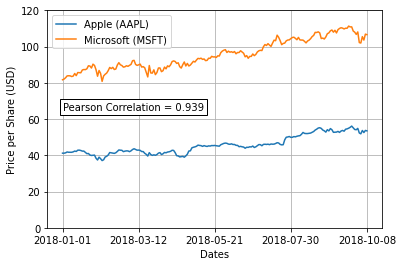

In [208]:
ax = plt.axes()
ax.grid(which='both');
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax=plt.plot(x_axis[:201],stock_dictionary['AAPL'][0][0:201],label='Apple (AAPL)')
ax=plt.plot(x_axis[:201],stock_dictionary['MSFT'][0][0:201],label='Microsoft (MSFT)')

ax=plt.xlabel('Dates')
ax=plt.ylabel('Price per Share (USD)')
ax=plt.text(0,65,'Pearson Correlation = 0.939',bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=1))
ax=plt.legend()
ax=plt.ylim((0,120))
ax=plt.savefig('Correlation_Stocks.png',dpi=500)

In [236]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2018,1,1)
end_dt = date(2021,1,1)

weekdays = [5,6]
x_axis=[]
for dt in daterange(start_dt, end_dt):
    if dt.weekday() not in weekdays:                    # to print only the weekdates
        x_axis.append(dt.strftime("%Y-%m-%d"))
x_axis=x_axis[:695]

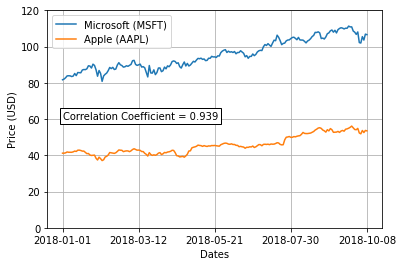

In [296]:
ax = plt.axes()
ax.grid(which='both');
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax=plt.plot(x_axis,a,label='Assortativity')
ax=plt.plot(x_axis[:201],stock_dictionary['MSFT'][0][0:201],label='Microsoft (MSFT)')
ax=plt.plot(x_axis[:201],stock_dictionary['AAPL'][0][0:201],label='Apple (AAPL)')

ax=plt.xlabel('Dates')
ax=plt.ylabel('Price (USD)')
ax=plt.text(0,60,'Correlation Coefficient = 0.939',bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=1))
ax=plt.legend(loc='upper left')
#ax=plt.vlines('2019-11-01',-1,1,colors='k',linestyles='dotted')
ax=plt.ylim((0,120))
ax=plt.savefig('Correlation_Stocks.png',dpi=500)

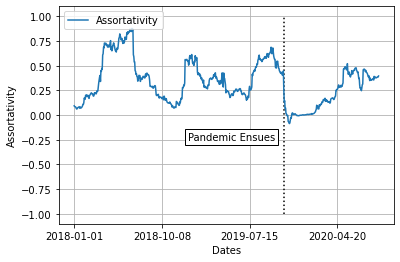

In [297]:
ax = plt.axes()
ax.grid(which='both');
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax=plt.plot(x_axis,a,label='Assortativity')
#ax=plt.plot(x_axis[:201],stock_dictionary['MSFT'][0][0:201],label='Microsoft (MSFT)')

ax=plt.xlabel('Dates')
ax=plt.ylabel('Assortativity')
ax=plt.text(260,-0.25,'Pandemic Ensues',bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=1))
ax=plt.legend(loc='upper left')
ax=plt.vlines('2019-11-01',-1,1,colors='k',linestyles='dotted')
#ax=plt.ylim((-1,1))
ax=plt.savefig('Assortativity_Stocks.png',dpi=500)

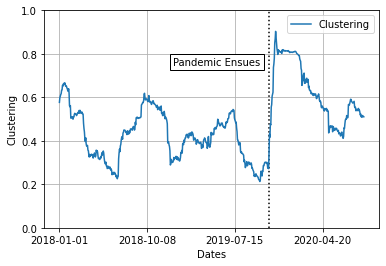

In [298]:
ax = plt.axes()
ax.grid(which='both');
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax=plt.plot(x_axis,b,label='Clustering')
#ax=plt.plot(x_axis[:201],stock_dictionary['MSFT'][0][0:201],label='Microsoft (MSFT)')

ax=plt.xlabel('Dates')
ax=plt.ylabel('Clustering')
ax=plt.text(260,0.75,'Pandemic Ensues',bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=1))
ax=plt.legend()
ax=plt.vlines('2019-11-01',0,1,colors='k',linestyles='dotted')
ax=plt.ylim((0,1))
ax=plt.savefig('Clustering_Stocks.png',dpi=500)

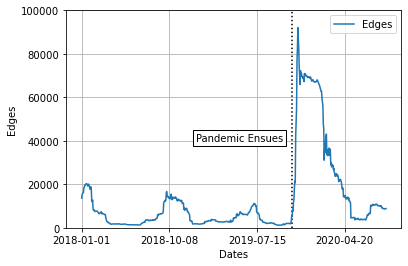

In [300]:
ax = plt.axes()
ax.grid(which='both');
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax=plt.plot(x_axis,c,label='Edges')
#ax=plt.plot(x_axis[:201],stock_dictionary['MSFT'][0][0:201],label='Microsoft (MSFT)')

ax=plt.xlabel('Dates')
ax=plt.ylabel('Edges')
ax=plt.text(260,40000,'Pandemic Ensues',bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="k", lw=1))
ax=plt.legend()
ax=plt.vlines('2019-11-01',0,100000,colors='k',linestyles='dotted')
ax=plt.ylim((0,100000))
ax=plt.savefig('Edge Density_Stocks.png',dpi=500)